In [1]:
#!/usr/bin/env python

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

from datetime import datetime
from isoweek import Week
from cmdstanpy import CmdStanModel
from cmdstanpy import from_csv
import glob

from numba import njit

In [2]:
csv_files = glob.glob('stan_output/sinusoid_2025/*20250404104108*.csv') # 
print(csv_files)

fit = from_csv(csv_files)

['stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_3.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_2.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_4.csv', 'stan_output/sinusoid_2025/sirs_sinusoid_dt-20250404104108_1.csv']


In [3]:
# The individual parameter means:
for var in ['S0', 'logx_I0', 'beta0', 'dbeta', 'betaphase', 'sigma_obs', 'rho', 'delta']:
    print(f"{var}: {fit.stan_variable(var).mean()}")

S0: 0.5689698045833333
logx_I0: -2.590903866666667
beta0: 0.7167610620833333
dbeta: 0.1855407425
betaphase: 3.5961723291666665
sigma_obs: 0.016248512791666666
rho: 0.019226591791666667
delta: 0.001713115354166667


In [4]:
df_draws = fit.draws_pd()
lp = df_draws["lp__"]  # log posterior column
imax = np.argmax(lp)  # index of sample with highest lp__
best_draw = df_draws.iloc[imax]

In [5]:
def best_draw_to_dict(row):
    result = {}
    for col in row.index:
        # attempt to match something like "paramName[123]"
        m = re.match(r"(.*)\[(\d+)\]$", col)
        if m:
            base_name = m.group(1)
            idx = int(m.group(2))  # 1-based index from Stan
            val = row[col]

            if base_name not in result:
                result[base_name] = {}
            result[base_name][idx] = val
        else:
            result[col] = row[col]

    for k, v in list(result.items()):
        if isinstance(v, dict):
            max_idx = max(v.keys())
            arr = np.empty(max_idx, dtype=float)
            for i in range(1, max_idx + 1):
                arr[i - 1] = v[i]
            result[k] = arr
    return result

# Usage with your best_draw
best_draw_dict = best_draw_to_dict(best_draw)


In [6]:
@njit
def SIRS(beta0, dbeta, betaphase, gamma, mu, delta, S0, I0, T0, T1, noise_level=0.0):
    timesteps_per_unit_time = 4
    dt = 1.0/timesteps_per_unit_time
    
    n_timesteps = int((T0 + T1) * timesteps_per_unit_time)
    ts = np.linspace(0, T0+T1, n_timesteps)
    R0 = 1-I0-S0
    S = np.zeros(n_timesteps)
    I = np.zeros(n_timesteps)
    R = np.zeros(n_timesteps)
    S[0] = S0
    I[0] = I0
    R[0] = R0

    if noise_level > 0:
        alpha = dt/noise_level**2
        beta = noise_level**2
        k_shape = alpha
        theta_scale = beta
    
    for i in range(1, len(ts)):
        t = ts[i]
        beta = beta0 * (1 + dbeta * np.sin(2 * np.pi * t/52 + betaphase))
        if t > T0:
            if noise_level > 0:
                DeltaGamma_loc = np.random.gamma(k_shape, theta_scale)
                noise = DeltaGamma_loc/dt
                beta = beta * noise
        foi = beta * I[i-1]
        Sout = (1 - np.exp(-(foi + mu) * dt)) * S[i - 1]
        StoI = foi / (foi + mu) * Sout
        Iout = (1 - np.exp(-(gamma + mu) * dt)) * I[i - 1]
        ItoR = gamma / (gamma + mu) * Iout
        Rout = (1 - np.exp(-(delta + mu) * dt)) * R[i - 1]
        RtoS = Rout * delta/(delta + mu);
        S[i] = S[i - 1] - Sout + mu * dt + RtoS
        I[i] = I[i - 1] + StoI - Iout
        R[i] = R[i - 1] + ItoR - Rout
    return S, I, R, ts

In [7]:
beta0 = best_draw_dict['beta0']
dbeta = best_draw_dict['dbeta']
betaphase = best_draw_dict['betaphase']
gamma = 1/2.5
mu = 1/(80.0 * 52)
delta = best_draw_dict['delta']
S0 = best_draw_dict['S0']
I0 = best_draw_dict['I0']

Text(0.5, 0, 'Years')

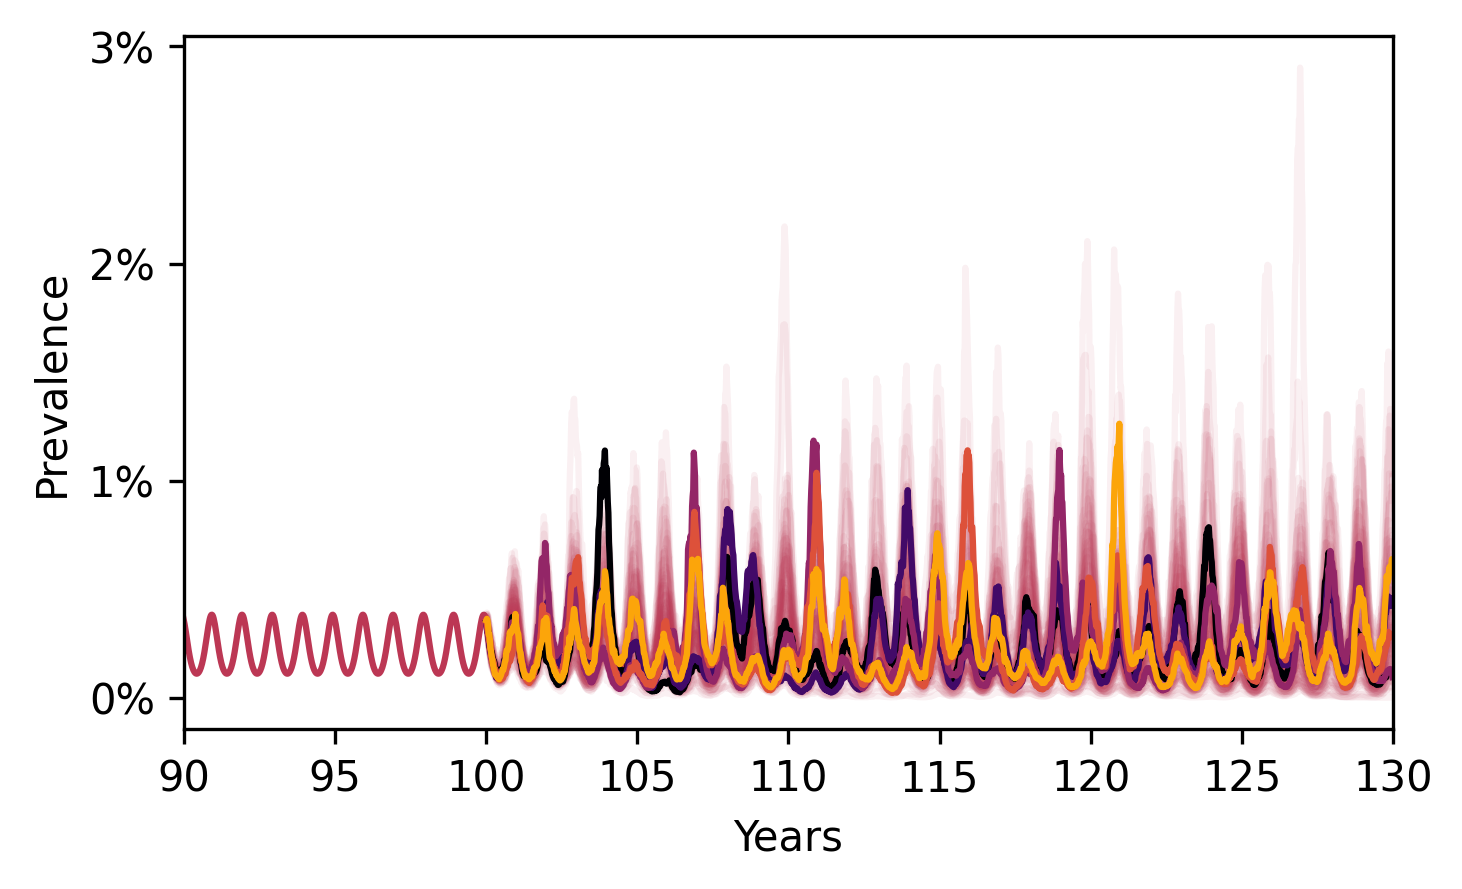

In [8]:
prolong_weeks = 300

noise_level = 0.15

plt.figure(figsize=(5.2, 3), dpi=300)


T0 = 100*52 # Weeks before adding noise
T1 = 30*52  # Weeks with noise


n_realizations = 95

np.random.seed(0)

# Plot until T0:
S, I, R, ts = SIRS(beta0, dbeta, betaphase, gamma, mu, delta, S0, I0, T0, T1, noise_level=noise_level)
I_subsampled = I[::4]
t_subsampled = ts[::4]/52
color = plt.cm.inferno(0.5) 
mask = t_subsampled <= T0/52
__ = plt.plot(t_subsampled[mask], 100*I_subsampled[mask], alpha=1, color=color, linewidth=1.5)

for i in range(n_realizations):
    S, I, R, ts = SIRS(beta0, dbeta, betaphase, gamma, mu, delta, S0, I0, T0, T1, noise_level=noise_level)
    I_subsampled = I[::4]
    t_subsampled = ts[::4]/52
    color = plt.cm.inferno(0.5) 
    mask = t_subsampled > T0/52
    if n_realizations < 10:
        color = plt.cm.inferno(i/n_realizations)
        __ = plt.plot(t_subsampled[mask], 100*I_subsampled[mask], alpha=min(1,7/n_realizations), color=color, linewidth=1.5)
    else:
        __ = plt.plot(t_subsampled[mask], 100*I_subsampled[mask], alpha=min(1,7/n_realizations), color=color, linewidth=1.5)

n_realizations = 5

for i in range(n_realizations):
    S, I, R, ts = SIRS(beta0, dbeta, betaphase, gamma, mu, delta, S0, I0, T0, T1, noise_level=noise_level)
    I_subsampled = I[::4]
    t_subsampled = ts[::4]/52
    color = plt.cm.inferno(0.5)  
    mask = t_subsampled > T0/52
    if n_realizations < 10:
        color = plt.cm.inferno(i/n_realizations)
        __ = plt.plot(t_subsampled[mask], 100*I_subsampled[mask], alpha=min(1,7/n_realizations), color=color, linewidth=1.5)
    else:
        __ = plt.plot(t_subsampled[mask], 100*I_subsampled[mask], alpha=min(1,7/n_realizations), color=color, linewidth=1.5)

#plt.ylim([-0.1, ylim_max])
plt.yticks([0, 1, 2, 3], labels=['0%','1%','2%','3%'])

plt.xlim(T0/52-10, (T0+T1)/52)

#ax = plt.gca()
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

plt.ylabel("Prevalence")
#plt.legend(loc="upper left")
plt.xlabel("Years")